# Cookie Cats A/B-testing
## 1. Gate at level 30 VS. Gate at level 40

Cookie Cats</a> is a hugely popular mobile puzzle game developed by <a href="http://tactile.dk">Tactile Entertainment</a>. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.

Players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress.

But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.
<p><img src="https://assets.datacamp.com/production/project_184/img/cc_gates.png" alt></p>

## 2. The AB-test data
<p>The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. As a sanity check, let's see if there are roughly the same number of players in each AB group. </p>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import scipy.stats as stats

In [2]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.groupby('version')['userid'].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

## 3. Let's see distribution of game rounds played

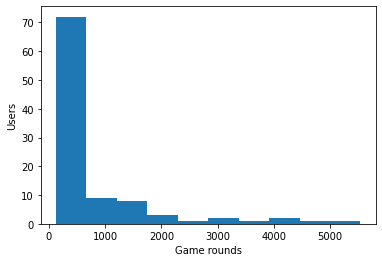

In [4]:
plot_df = df.groupby('sum_gamerounds')['userid'].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot(x='sum_gamerounds', y='userid', kind='hist')
ax.set_xlabel("Game rounds")
ax.set_ylabel("Users")
plt.show()

#### Majority of players install the game, but do not play it (0 game rounds)

## 4. Now let's see the difference in day-1 retention with both 40 and 30 level gates using bootstrapping.

In [5]:
df.groupby('version')['retention_1'].mean() * 100


version
gate_30    44.818792
gate_40    44.228275
Name: retention_1, dtype: float64

In [6]:
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)

version
gate_30    0.448265
gate_40    0.442222
dtype: float64


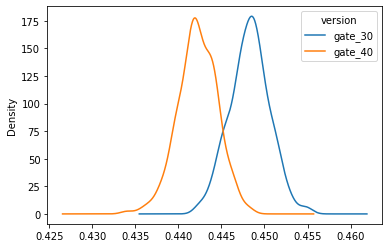

In [7]:
boot_1d = pd.DataFrame(boot_1d)
print(boot_1d.mean())
boot_1d.plot(kind='kde')
plt.show()

#### Day 1 retention is not really interesting for us, since users usually require around 7 days to reach the gate.

## 5. It seems that there was a decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%).  Now let's find the 7-day retention using bootstrapping.

In [8]:
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)

version
gate_30    0.190130
gate_40    0.181983
dtype: float64


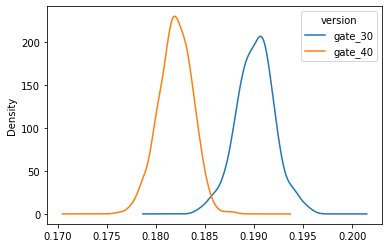

In [9]:
boot_7d = pd.DataFrame(boot_7d)
print(boot_7d.mean())
boot_7d.plot(kind='kde')
plt.show()

In [10]:
gate30_7d = boot_7d['gate_30'] # Group A
gate40_7d = boot_7d['gate_40'] # Group B

## 6. Reviewing the results. Testing hypothesies 

### Testing normality of distribution using Shaphiro Wilks test

In [11]:
if shapiro(gate30_7d)[1] > 0.05: 
    print('Normal distribution for group A')
else:
    print('Not normal distribution for group A')
if shapiro(gate40_7d)[1] > 0.05:
    print('Normal distribution for group B')
else:
    print('Not normal distribution for group B')
# H0: Distribution is Normal! - True
# H1: Distribution is not Normal! - False

Normal distribution for group A
Normal distribution for group B


### Testing the Homogeneity Assumption

In [12]:
if stats.levene(gate30_7d, gate40_7d)[1] > 0.05:
    print('Homogenity')
else:
    print('Heterogeneity')
# H0: Homogenity - True
# H1: Heterogeneity - False

Heterogeneity


Distributions are normal and heterogenetic => Performing t-test with 'equal_var' as False

### Performing t-test


H0: There is no statistically significant difference between group A and group B  
H1: There is statistically significant difference between group A and group B

In [15]:
t_test = stats.ttest_ind(gate30_7d, gate40_7d, equal_var=False)

In [16]:
if t_test[1] < 0.05:
    print(f'P-value is {t_test[1]} which is less than 0.05, so H0 rejected')
else:
    print(f'P-value is {t_test[1]} which is more than 0.05, so H1 rejected')

P-value is 0.0 which is less than 0.05, so H0 rejected


## Conclusion:  
Placing the gate at level 30 makes 7 day retention higher than placing the gate at level 40